# Assignment 3
## Exercise 1
### Task 1.1
Original code:

In [33]:
def gauss_seidel(f):
    newf = f.copy()

    for i in range(1, newf.shape[0] - 1):
        for j in range(1, newf.shape[1] - 1):
            newf[i, j] = 0.25 * (
                newf[i, j + 1] + newf[i, j - 1] + newf[i + 1, j] + newf[i - 1, j]
            )

    return newf

In [34]:
import numpy as np

In [35]:
def gen_matrix(n):
    f = np.random.rand(n, n)
    f[0, :] = 0
    f[-1, :] = 0
    f[:, 0] = 0
    f[:, -1] = 0

    return f

In [36]:
import matplotlib.pyplot as plt
import timeit

In [37]:
gridSize = [5,10,20,50,75,100,150,200]
times = []
for N in gridSize:
    x = gen_matrix(N)

    start = timeit.default_timer()
    for i in range(1000):
        x = gauss_seidel(x)
    stop = timeit.default_timer()
    times.append(stop-start)

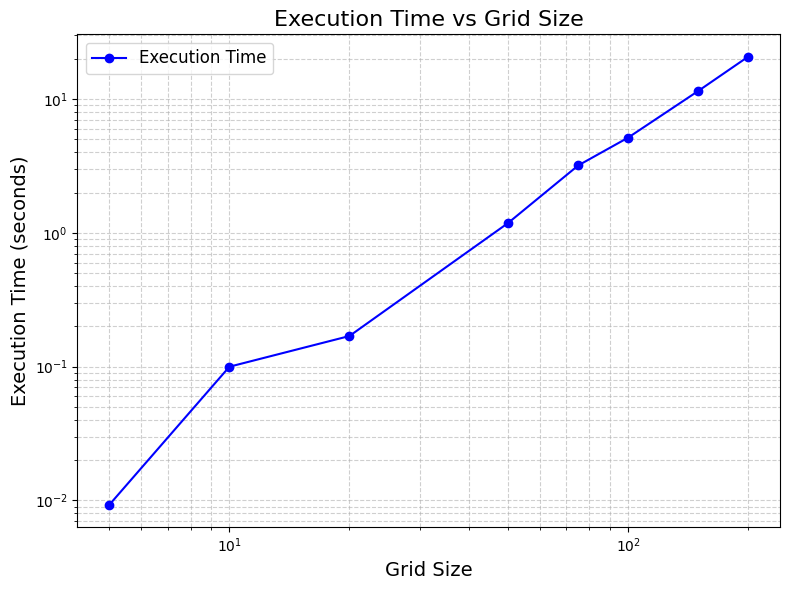

In [38]:
# Task 1.1 The solver is shown to be exponential
x = gridSize
y = times

plt.figure(figsize=(8, 6))
plt.plot(x, y, marker="o", linestyle="-", color="b", label="Execution Time")
plt.title("Execution Time vs Grid Size", fontsize=16)
plt.xlabel("Grid Size", fontsize=14)
plt.ylabel("Execution Time (seconds)", fontsize=14)
plt.xscale("log") 
plt.yscale("log") 
plt.grid(
    True, which="both", linestyle="--", alpha=0.6
) 
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()



### Task 1.2
Profile results:

In [39]:
%load_ext line_profiler

In [40]:
x = gen_matrix(100)
%lprun -f gauss_seidel gauss_seidel(x)

Timer unit: 1e-09 s

Total time: 0.010446 s
File: /var/folders/l9/r5f8pkf159j52lh6xnjp3rd00000gn/T/ipykernel_2167/4032982141.py
Function: gauss_seidel at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def gauss_seidel(f):
     2         1     258000.0 258000.0      2.5      newf = f.copy()
     3                                           
     4        99      12000.0    121.2      0.1      for i in range(1, newf.shape[0] - 1):
     5      9702    1207000.0    124.4     11.6          for j in range(1, newf.shape[1] - 1):
     6     19208    3618000.0    188.4     34.6              newf[i, j] = 0.25 * (
     7      9604    5350000.0    557.1     51.2                  newf[i, j + 1] + newf[i, j - 1] + newf[i + 1, j] + newf[i - 1, j]
     8                                                       )
     9                                           
    10         1       1000.0   1000.0      0.0      return newf

### Task 1.3

In [41]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [42]:
%%cython --annotate
def gauss_seidel(f):
    newf = f.copy()

    for i in range(1, newf.shape[0] - 1):
        for j in range(1, newf.shape[1] - 1):
            newf[i, j] = 0.25 * (
                newf[i, j + 1] + newf[i, j - 1] + newf[i + 1, j] + newf[i - 1, j]
            )

    return newf

### Task 1.4

In [43]:
%%cython --annotate
cimport numpy as np

def gauss_seidel(np.ndarray[double, ndim=2] f):
    cdef int i, j
    cdef np.ndarray[double, ndim=2] newf = f.copy()
    
    cdef int iarr = newf.shape[0]
    cdef int jarr = newf.shape[1]

    for i in range(1, iarr - 1):
        for j in range(1, jarr - 1):
            newf[i, j] = 0.25 * (
                newf[i, j + 1] + newf[i, j - 1] + newf[i + 1, j] + newf[i - 1, j]
            )

    return newf

In [44]:
gridSize = [150,200,300,400,500,1000,3000]
times = []
for N in gridSize:
    x = gen_matrix(N)

    start = timeit.default_timer()
    for i in range(1000):
        x = gauss_seidel(x)
    stop = timeit.default_timer()
    times.append(stop - start)

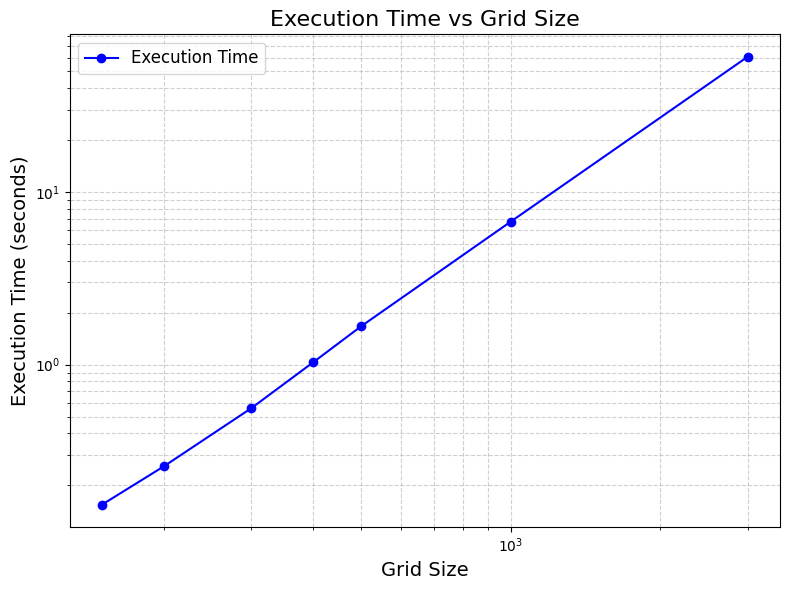

In [45]:
x = gridSize
y = times

plt.figure(figsize=(8, 6))
plt.plot(x, y, marker="o", linestyle="-", color="b", label="Execution Time")
plt.title("Execution Time vs Grid Size", fontsize=16)
plt.xlabel("Grid Size", fontsize=14)
plt.ylabel("Execution Time (seconds)", fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


### Task 1.5
This was all run on google colab, so the results are not very reliable.

In [46]:
import torch
from torch import roll, zeros

import numpy as np
import matplotlib.pyplot as plt
import timeit

import h5py


def gauss_seidel(f):
    f = f.to("cuda") if not f.is_cuda else f
    newf = f.clone()

    tmp = 0.25 * (
        torch.roll(newf, 1, 0)
        + torch.roll(newf, -1, 0)
        + torch.roll(newf, 1, 1)
        + torch.roll(newf, -1, 1)
    )

    newf[1:-1, 1:-1] = tmp[1:-1, 1:-1]

    return newf


def gen_matrix(n):
    f = torch.rand((n, n), dtype=torch.float64)
    f[0, :] = 0
    f[-1, :] = 0
    f[:, 0] = 0
    f[:, -1] = 0

    return f


gridSize = [10000]
times = []
for N in gridSize:
    x = gen_matrix(N)

    start = timeit.default_timer()
    for i in range(1000):
        x = gauss_seidel(x)
    stop = timeit.default_timer()
    times.append(stop - start)
    with h5py.File("results1.h5", "w") as hdf:
        hdf.create_dataset("newgrid", data=x.cpu().numpy())

    print(f"Saved HDF5 file: result_tensor.h5")

x = gridSize
y = times

plt.figure(figsize=(8, 6))
plt.plot(x, y, marker="o", linestyle="-", color="b", label="Execution Time")
plt.title("Execution Time vs Grid Size", fontsize=16)
plt.xlabel("Grid Size", fontsize=14)
plt.ylabel("Execution Time (seconds)", fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'h5py'

### Task 1.6

In [47]:
import cupy

import numpy as np
import matplotlib.pyplot as plt
import timeit

def gauss_seidel(f):
    f = cupy.asarray(f)
    newf = f.copy()

    tmp = 0.25 * (
        cupy.roll(newf, 1, 0)
        + cupy.roll(newf, -1, 0)
        + cupy.roll(newf, 1, 1)
        + cupy.roll(newf, -1, 1)
    )

    newf[1:-1, 1:-1] = tmp[1:-1, 1:-1]

    return newf


def gen_matrix(n):
    f = cupy.random.rand(n, n, dtype=cupy.float64)
    f[0, :] = 0
    f[-1, :] = 0
    f[:, 0] = 0
    f[:, -1] = 0

    return f


gridSize = [150, 200, 300, 400, 500, 1000, 10000]
times = []
for N in gridSize:
    x = gen_matrix(N)

    start = timeit.default_timer()
    for i in range(1000):
        x = gauss_seidel(x)
    stop = timeit.default_timer()
    times.append(stop - start)

x = gridSize
y = times

plt.figure(figsize=(8, 6))
plt.plot(x, y, marker="o", linestyle="-", color="b", label="Execution Time")
plt.title("Execution Time vs Grid Size", fontsize=16)
plt.xlabel("Grid Size", fontsize=14)
plt.ylabel("Execution Time (seconds)", fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'cupy'

### Task 1.7
All runs of Tensor and CuPy ran b

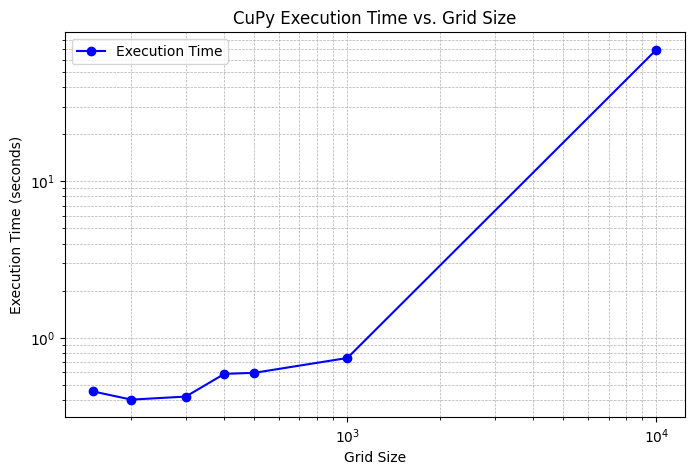

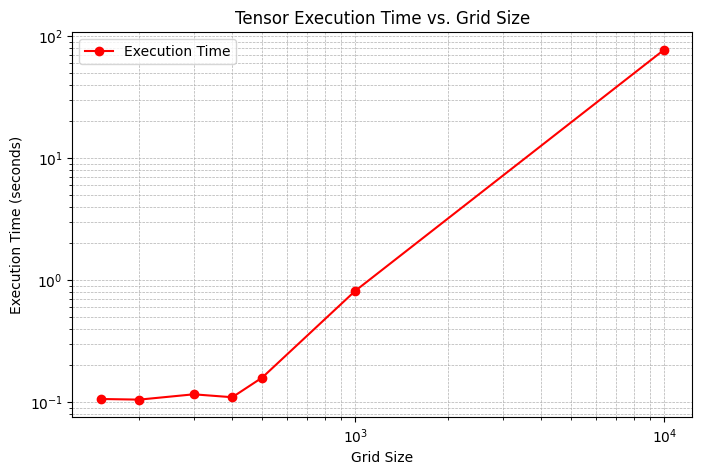

In [48]:
# Data
grid_sizes = [150, 200, 300, 400, 500, 1000, 10000]
execution_times = [
    0.45334914299974116,
    0.4014921319999303,
    0.4199548940000568,
    0.5865755900003933,
    0.5958486270001231,
    0.7412477389998458,
    69.54287742199995,
]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(
    grid_sizes,
    execution_times,
    marker="o",
    linestyle="-",
    color="b",
    label="Execution Time",
)

# Labels and Title
plt.xlabel("Grid Size")
plt.ylabel("Execution Time (seconds)")
plt.title("CuPy Execution Time vs. Grid Size")
plt.xscale("log")  # Log scale for better visualization
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Show Plot
plt.show()

# Data for Tensor execution times
tensor_execution_times = [
    0.10585074300024644,
    0.10457580899992536,
    0.11559838500033948,
    0.10940038099988669,
    0.15858825000032084,
    0.8145255859999452,
    77.30465151800036,
]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(
    grid_sizes,
    tensor_execution_times,
    marker="o",
    linestyle="-",
    color="r",
    label="Execution Time",
)

# Labels and Title
plt.xlabel("Grid Size")
plt.ylabel("Execution Time (seconds)")
plt.title("Tensor Execution Time vs. Grid Size")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Show Plot
plt.show()

### Task 1.8

## Bonus
Original code:

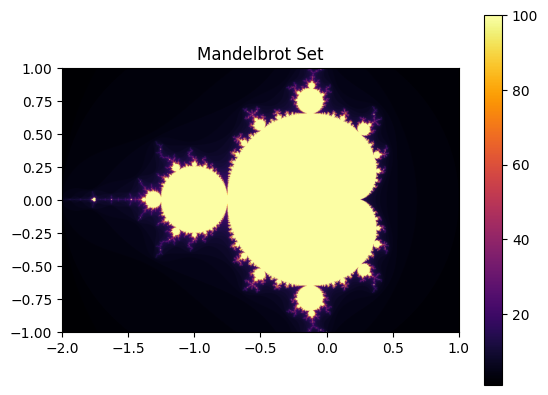

In [49]:
def mandelbrot(c, max_iter=100):
    """Computes the number of iterations before divergence."""
    z = 0
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z * z + c
    return max_iter


def mandelbrot_set(width, height, x_min, x_max, y_min, y_max, max_iter=100):
    """Generates the Mandelbrot set image."""
    x_vals = np.linspace(x_min, x_max, width)
    y_vals = np.linspace(y_min, y_max, height)
    image = np.zeros((height, width))

    for i in range(height):
        for j in range(width):
            c = complex(x_vals[j], y_vals[i])
            image[i, j] = mandelbrot(c, max_iter)

    return image


# Parameters
width, height = 1000, 800
x_min, x_max, y_min, y_max = -2, 1, -1, 1

# Generate fractal
image = mandelbrot_set(width, height, x_min, x_max, y_min, y_max)

# Display
plt.imshow(image, cmap="inferno", extent=[x_min, x_max, y_min, y_max])
plt.colorbar()
plt.title("Mandelbrot Set")
plt.show()


Cython code:

In [53]:
%%cython --annotate
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as cnp

def cython_linspace(double start, double stop, int num):
    cdef int i
    cdef double step
    cdef cnp.ndarray[cnp.float64_t, ndim=1] result = np.empty(num, dtype=np.float64)

    if num == 1:
        result[0] = start
        return result

    step = (stop - start) / (num - 1)
    
    for i in range(num):
        result[i] = start + i * step

    return result

def mandelbrot(complex c, int max_iter=100):
    """Computes the number of iterations before divergence."""
    
    cdef int n
    cdef complex z = 0
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z * z + c
    return max_iter

def mandelbrot_set(int width, int height, double x_min, double x_max, double y_min, double y_max, int max_iter=100):
    """Generates the Mandelbrot set image."""
    
    cdef cnp.ndarray[cnp.float64_t, ndim=2] image = np.zeros((height, width), dtype=np.float64)
    cdef cnp.ndarray[cnp.float64_t, ndim=1] x_vals = cython_linspace(x_min, x_max, width)
    cdef cnp.ndarray[cnp.float64_t, ndim=1] y_vals = cython_linspace(y_min, y_max, height)

    cdef int i, j
    cdef complex c
    for i in range(height):
        for j in range(width):
            c = complex(x_vals[j], y_vals[i])
            image[i, j] = mandelbrot(c, max_iter)

    return image

# Parameters
width, height = 1000, 800
x_min, x_max, y_min, y_max = -2, 1, -1, 1

# Generate fractal
image = mandelbrot_set(width, height, x_min, x_max, y_min, y_max)

# Display
plt.imshow(image, cmap="inferno", extent=[x_min, x_max, y_min, y_max])
plt.colorbar()
plt.title("Mandelbrot Set")
plt.show()

### B.2

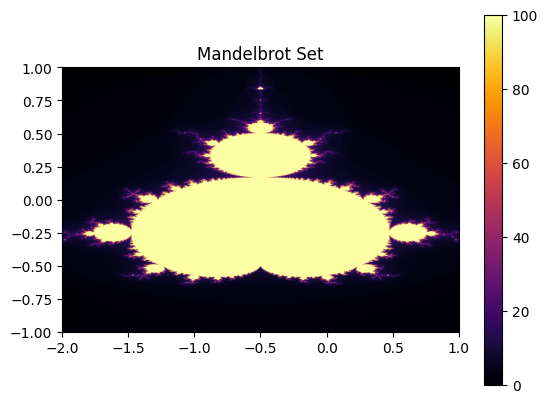

In [ ]:
import torch
import matplotlib.pyplot as plt


def mandelbrot_set(width, height, x_min, x_max, y_min, y_max, max_iter=100):
    """Generates the Mandelbrot set image."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    x_vals = torch.linspace(x_min, x_max, width, device=device)
    y_vals = torch.linspace(y_min, y_max, height, device=device)

    X, Y = torch.meshgrid(x_vals, y_vals, indexing="ij")
    C = X + 1j * Y

    Z = torch.zeros_like(C, device=device)
    mask = torch.ones(C.shape, dtype=torch.bool, device=device)   
    iterations = torch.zeros(C.shape, dtype=torch.int32, device=device)
         
    for i in range(max_iter):
        Z[mask] = Z[mask]**2 + C[mask]
        
        iter = mask & (torch.abs(Z) > 2)
        iterations[iter] = i
        
        mask = mask & (torch.abs(Z) <= 2)
        if not mask.any():
            break
    
    iterations[mask] = max_iter 

    return iterations.cpu().numpy()


# Parameters
width, height = 1000, 800
x_min, x_max, y_min, y_max = -2, 1, -1, 1

# Generate fractal
image = mandelbrot_set(width, height, x_min, x_max, y_min, y_max)

# Display
plt.imshow(image.T, cmap="inferno", extent=[x_min, x_max, y_min, y_max])
plt.colorbar()
plt.title("Mandelbrot Set")
plt.show()
